# Usage of Deep Learning Models to Predict NBA Game Outcomes

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

go_back = '../data/'

# Load your dataset
df = pd.read_csv(go_back + 'all_data_train.csv')
df = df.drop(['Unnamed: 0','score', 'opponentScore', 'total', 'secondHalfTotal'], axis = 1)
df


2024-04-12 18:28:57.972375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,date,team,opponent,moneyLine,opponentMoneyLine,spread,FG%,FG3%,FT%,REB/G,...,REB/G_opp,AST/G_opp,STL/G_opp,BLK/G_opp,TOV/G_opp,PF/G_opp,PTS/G_opp,win%_opp,home,outcome
0,2008-10-31,Chicago,Boston,450.0,-600.0,10.0,0.507246,0.416667,0.750000,40.000000,...,36.000000,16.000000,10.000000,0.000000,16.000000,28.000000,90.000000,1.000000,0,0
1,2008-10-31,Boston,Chicago,-600.0,450.0,-10.0,0.445946,0.214286,0.617647,36.000000,...,40.000000,27.000000,9.000000,6.000000,18.000000,18.000000,108.000000,1.000000,1,1
2,2008-10-31,LA Clippers,Denver,100.0,-120.0,1.5,0.384615,0.227273,0.608696,32.000000,...,35.000000,17.000000,12.000000,3.000000,13.000000,27.000000,94.000000,0.000000,1,0
3,2008-10-31,Toronto,Golden State,-280.0,240.0,-6.5,0.444444,0.625000,0.764706,33.000000,...,39.000000,18.000000,10.000000,5.000000,13.000000,26.000000,103.000000,0.000000,1,1
4,2008-10-31,Denver,LA Clippers,-120.0,100.0,-1.5,0.467532,0.307692,0.642857,35.000000,...,32.000000,24.000000,9.000000,5.000000,18.000000,29.000000,79.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22491,2021-04-10,Oklahoma City,Philadelphia,450.0,-600.0,10.0,0.444910,0.347918,0.737720,44.942308,...,46.057692,23.173077,8.846154,6.230769,14.538462,20.538462,113.653846,0.673077,1,0
22492,2021-04-10,Detroit,Portland,550.0,-800.0,11.0,0.448114,0.355769,0.773171,42.557692,...,43.843137,20.333333,7.098039,5.176471,10.882353,19.352941,114.980392,0.588235,0,0
22493,2021-04-10,Utah,Sacramento,-800.0,550.0,-11.0,0.467000,0.390255,0.789520,48.307692,...,42.269231,25.673077,6.711538,4.923077,12.846154,19.519231,114.365385,0.423077,1,1
22494,2021-04-10,Cleveland,Toronto,-140.0,120.0,-3.0,0.451056,0.335192,0.733275,42.941176,...,41.269231,24.384615,8.461538,5.519231,12.596154,21.961538,111.923077,0.384615,1,0


In [2]:
# preprocessing
X = df.drop(['team', 'opponent', 'outcome', 'date'], axis = 1)
y = df['outcome']
X

,moneyLine,opponentMoneyLine,spread,FG%,FG3%,FT%,REB/G,AST/G,STL/G,BLK/G,...,FT%_opp,REB/G_opp,AST/G_opp,STL/G_opp,BLK/G_opp,TOV/G_opp,PF/G_opp,PTS/G_opp,win%_opp,home
0,450.0,-600.0,10.0,0.507246,0.416667,0.750000,40.000000,27.000000,9.000000,6.000000,...,0.617647,36.000000,16.000000,10.000000,0.000000,16.000000,28.000000,90.000000,1.000000,0
1,-600.0,450.0,-10.0,0.445946,0.214286,0.617647,36.000000,16.000000,10.000000,0.000000,...,0.750000,40.000000,27.000000,9.000000,6.000000,18.000000,18.000000,108.000000,1.000000,1
2,100.0,-120.0,1.5,0.384615,0.227273,0.608696,32.000000,24.000000,9.000000,5.000000,...,0.642857,35.000000,17.000000,12.000000,3.000000,13.000000,27.000000,94.000000,0.000000,1
3,-280.0,240.0,-6.5,0.444444,0.625000,0.764706,33.000000,24.000000,8.000000,5.000000,...,0.687500,39.000000,18.000000,10.000000,5.000000,13.000000,26.000000,103.000000,0.000000,1
4,-120.0,100.0,-1.5,0.467532,0.307692,0.642857,35.000000,17.000000,12.000000,3.000000,...,0.608696,32.000000,24.000000,9.000000,5.000000,18.000000,29.000000,79.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22491,450.0,-600.0,10.0,0.444910,0.347918,0.737720,44.942308,22.557692,6.846154,4.576923,...,0.769062,46.057692,23.173077,8.846154,6.230769,14.538462,20.538462,113.653846,0.673077,1
22492,550.0,-800.0,11.0,0.448114,0.355769,0.773171,42.557692,24.519231,7.711538,5.076923,...,0.832418,43.843137,20.333333,7.098039,5.176471,10.882353,19.352941,114.980392,0.588235,0
22493,-800.0,550.0,-11.0,0.467000,0.390255,0.789520,48.307692,23.461538,6.500000,5.423077,...,0.740017,42.269231,25.673077,6.711538,4.923077,12.846154,19.519231,114.365385,0.423077,1
22494,-140.0,120.0,-3.0,0.451056,0.335192,0.733275,42.941176,23.529412,8.137255,4.960784,...,0.824670,41.269231,24.384615,8.461538,5.519231,12.596154,21.961538,111.923077,0.384615,1


# Data Preprocessing

We'll start off by turning our time series data into tensors highlighting stats of recent games. This makes the data in perfect shape for entering into our LSTM. For example, If we want to predict the sixth game of the season, the input will be all the statistics from the first five games and the output will be the result of the sixth game.

In [3]:
#Parameters for building out our model
n_timesteps = 5 #The number of past games we want to focus on for the outcome of the current game
n_features = X.shape[1] #highlights how many features from our final tensor we are showing the model




def create_sequences(data, labels, sequence_length = n_timesteps):
    """
    Create sequences of data with corresponding labels.
    
    :param data: Scaled features for all games.
    :param labels: Outcomes for all games.
    :param sequence_length: Number of games in each sequence (e.g., 5 for games 1-5).
    :return: Sequences of features and their corresponding outcome labels.
    """
    X, y = [], []

    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        # The label for a sequence is the outcome of the game following the sequence
        y.append(labels[i + sequence_length])  # The outcome of game a based on data from games (a - sequence_length, a)
    return np.array(X), np.array(y)

def preprocess_data(df, sequence_length = n_timesteps, scale = True):

    scaler = StandardScaler()
    team_data_tensors = {}
    
    df = df.drop(['opponent', 'date'], axis=1)
    for team in df['team'].unique():
        team_df = df[df['team'] == team]
        
        # Prepare features and labels
        features = team_df.drop(columns=['team', 'outcome'])
        labels = team_df['outcome'].values  # Outcomes as labels
        
        # Scale the features if we want to
        if scale:
            features_scaled = scaler.fit_transform(features)
        else:
            features_scaled = features
        
        # Create sequences and their corresponding labels
        X_team, y_team = create_sequences(features_scaled, labels, sequence_length)
        
        # Store the 3D tensor and labels for the team
        team_data_tensors[team] = (X_team, y_team)
        
    return team_data_tensors


team_data_tensors = preprocess_data(df, n_timesteps, False)

def concatenate_dict_items(my_dict):
    first_key, first_value = next(iter(my_dict.items()))
    first_dim = first_value[0].shape[1]
    second_dim = first_value[0].shape[2]

    fin_tensor = np.empty((0, first_dim, second_dim))
    fin_label_tensor = np.empty((0, ))

    for value in my_dict.values():

        fin_tensor = np.concatenate((fin_tensor, value[0]), axis=0)
        fin_label_tensor = np.concatenate((fin_label_tensor, value[1]))

    return fin_tensor, fin_label_tensor

fin_tensor, fin_label_tensor = concatenate_dict_items(team_data_tensors)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(fin_tensor, fin_label_tensor, test_size=0.2, shuffle= False, random_state = 42)

In [5]:
X_train[0]

array([[ 4.50000000e+02, -6.00000000e+02,  1.00000000e+01,
         5.07246377e-01,  4.16666667e-01,  7.50000000e-01,
         4.00000000e+01,  2.70000000e+01,  9.00000000e+00,
         6.00000000e+00,  1.80000000e+01,  1.80000000e+01,
         1.08000000e+02,  1.00000000e+00,  4.45945946e-01,
         2.14285714e-01,  6.17647059e-01,  3.60000000e+01,
         1.60000000e+01,  1.00000000e+01,  0.00000000e+00,
         1.60000000e+01,  2.80000000e+01,  9.00000000e+01,
         1.00000000e+00,  0.00000000e+00],
       [-3.80000000e+02,  3.10000000e+02, -8.00000000e+00,
         3.92156863e-01,  3.50000000e-01,  8.24324324e-01,
         4.20000000e+01,  1.90000000e+01,  8.50000000e+00,
         6.00000000e+00,  1.90000000e+01,  2.40000000e+01,
         9.40000000e+01,  5.00000000e-01,  3.88535032e-01,
         7.69230769e-02,  7.67441860e-01,  4.55000000e+01,
         1.10000000e+01,  6.50000000e+00,  6.50000000e+00,
         1.30000000e+01,  2.25000000e+01,  7.85000000e+01,
         5.00

# Using LSTM and GRU Architecture to Predict Game Outcome

In [ ]:
epochs = 10
batch_size = 32
learning_rate = 3e-4

#Function defining the model architecture of our LSTM model
def build_LSTM_model(units = 128, n_timesteps = n_timesteps, n_features = n_features, activation = 'relu'):

    # Using LSTM model architecture
    model = Sequential([
    LSTM(units, input_shape=(n_timesteps, n_features), return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    BatchNormalization(),
    LSTM(units, activation = activation, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    BatchNormalization(),
    LSTM(units, activation = activation, kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


lstm_model = build_LSTM_model()
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)




2024-04-12 18:11:37.372551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-12 18:11:37.372588: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-12 18:11:37.372626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-06afa86f-ced4-42c8-8a83-dce5632cbfe5): /proc/driver/nvidia/version does not exist
2024-04-12 18:11:37.372877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/10
504/504 [==============================] - 36s 62ms/step - loss: 

Given the fact that it performs considerably well above 50% for predicting the outcome between 2 teams, we could say that this model is learning from our data. We will also try a GRU architecture which is similar and trains faster with little expected performance loss.

In [ ]:


epochs = 10
batch_size = 32
learning_rate = 3e-4

def build_GRU_model(units = 128, n_timesteps = n_timesteps, n_features = n_features, activation = 'relu'):

    # Using GRU model architecture
    model = Sequential([
    GRU(units, input_shape=(n_timesteps, n_features), return_sequences=True, kernel_regularizer=l2(0.009)),
    Dropout(0.2),
    BatchNormalization(),
    GRU(units, activation = activation, return_sequences=True, kernel_regularizer=l2(0.009)),
    Dropout(0.2),
    BatchNormalization(),
    GRU(units, activation = activation, kernel_regularizer=l2(0.009)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
],)
    opt = Adam(learning_rate)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


gru_model = build_GRU_model()
history = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)




Epoch 1/10
504/504 [==============================] - 29s 49ms/step - loss: 1.1256 - accuracy: 0.5921 - val_loss: 0.7201 - val_accuracy: 0.5321
Epoch 2/10
504/504 [==============================] - 24s 48ms/step - loss: 0.6871 - accuracy: 0.5999 - val_loss: 0.7024 - val_accuracy: 0.5511
Epoch 3/10
504/504 [==============================] - 24s 48ms/step - loss: 0.6791 - accuracy: 0.6006 - val_loss: 0.6957 - val_accuracy: 0.5679
Epoch 4/10
504/504 [==============================] - 32s 64ms/step - loss: 0.6799 - accuracy: 0.5996 - val_loss: 0.7084 - val_accuracy: 0.5629
Epoch 5/10
504/504 [==============================] - 40s 80ms/step - loss: 0.6794 - accuracy: 0.5976 - val_loss: 0.6982 - val_accuracy: 0.5674
Epoch 6/10
504/504 [==============================] - 37s 73ms/step - loss: 0.6804 - accuracy: 0.5988 - val_loss: 0.7002 - val_accuracy: 0.5528
Epoch 7/10
504/504 [==============================] - 37s 73ms/step - loss: 0.6810 - accuracy: 0.5944 - val_loss: 0.7057 - val_accuracy:

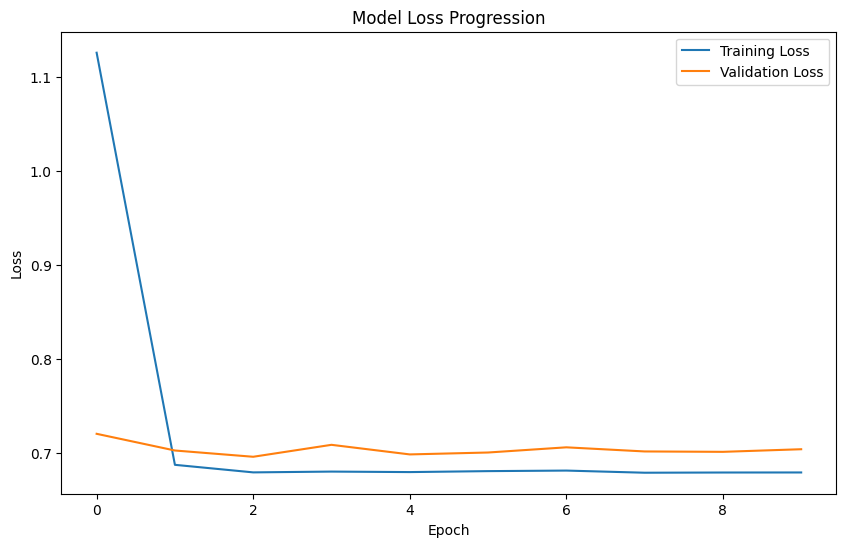

In [ ]:

def plot_loss_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Progression')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss_history(history)

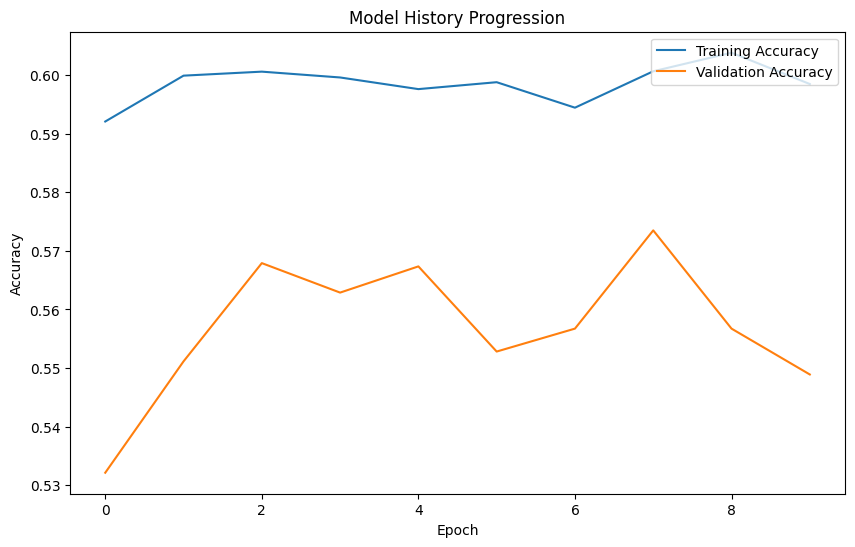

In [ ]:
def plot_acc_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model History Progression')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_acc_history(history)

In [ ]:
test_df = pd.read_csv(go_back + 'all_data_test.csv').drop(['Unnamed: 0','score', 'opponentScore', 'total', 'secondHalfTotal'], axis = 1)
team_data_tensors = preprocess_data(test_df, n_timesteps, False)
fin_test_tensor, fin_test_label_tensor = concatenate_dict_items(team_data_tensors)
gru_model.evaluate(fin_test_tensor, fin_test_label_tensor)

57/57 [==============================] - 1s 17ms/step - loss: 0.6884 - accuracy: 0.5805


[0.6884276866912842, 0.5804502964019775]

In [ ]:
fin_test_tensor.shape

(1821, 5, 26)

These models perform decently on unseen data. There isn't a huge drop off between training and testing performance.

# Grid Search

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

grid_model = KerasClassifier(build_fn=build_GRU_model, verbose=0)

#Parameters to perform grid search
param_grid = {
    'units': [128],
    'activation': ['relu', 'tanh'],
    'batch_size': [64],
    'epochs': [5, 10]
}

/tmp/ipykernel_181/4191160580.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasClassifier(build_fn=build_GRU_model, verbose=0)


Now, we will perform the actual grid search to find the best performing model.

In [ ]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(fin_tensor, fin_label_tensor)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.596574 using {'activation': 'tanh', 'batch_size': 64, 'epochs': 5, 'units': 128}


In [ ]:
grid_result.best_estimator_.model.evaluate(fin_test_tensor, fin_test_label_tensor)

57/57 [==============================] - 4s 20ms/step - loss: 0.6987 - accuracy: 0.5354


[0.6987152099609375, 0.5354201197624207]

It seems that after our grid search, the best possible model using this data doesn't go too high beyond the baseline.